In [67]:
#---------------------------------IMPORT LIBRARIES---------------------------------#
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from pandas import *
import pickle
%matplotlib inline
from tkinter import font
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [68]:
#---------------------------------GLOBAL VARIABLES---------------------------------#

#Chessboard dimensions
nx=9
ny=6

# Arrays to store object points and image points from all the images.
objpoints = [] # Points in 3D
imgpoints = [] # Point in 2D
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

From 3D point and its 2D point

[0. 0. 0.]
[[483.04465 241.91763]]


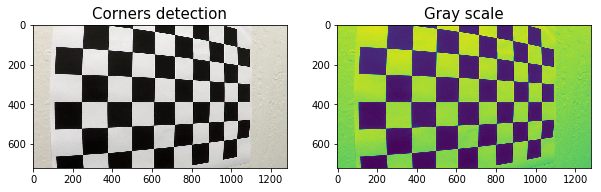

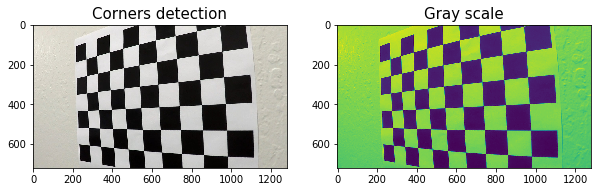

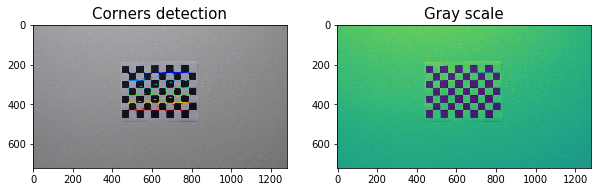

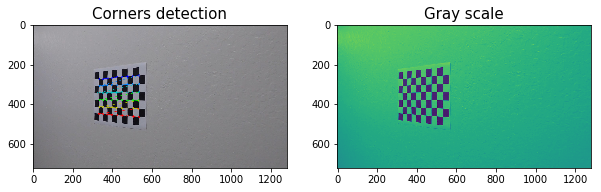

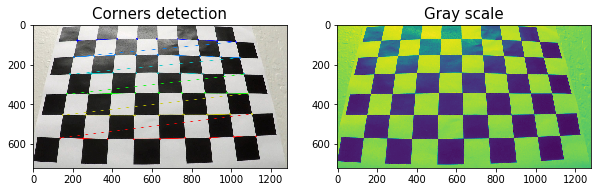

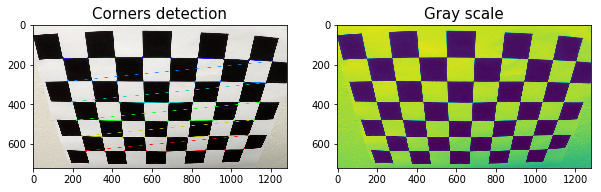

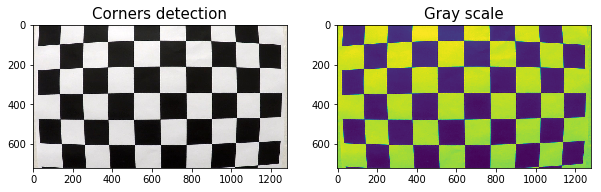

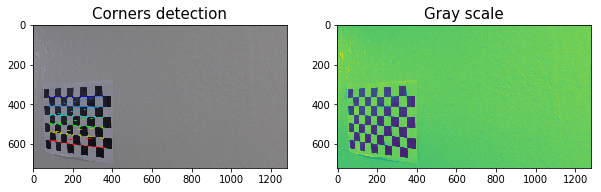

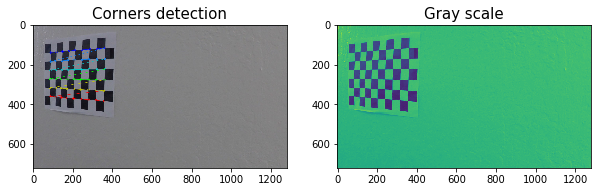

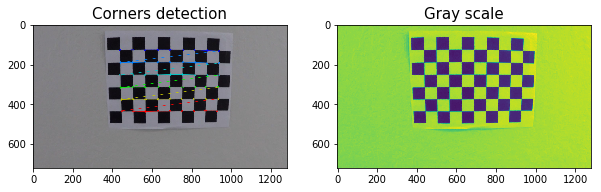

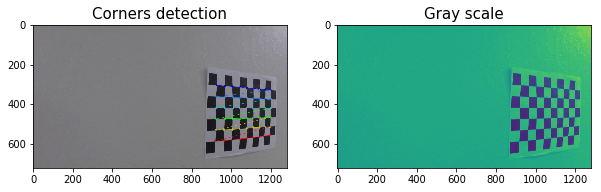

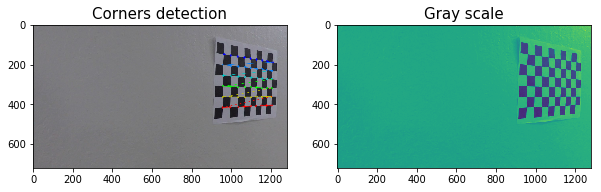

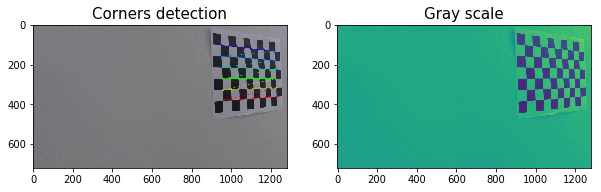

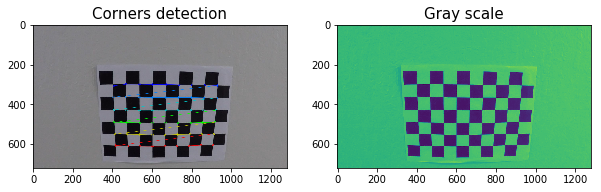

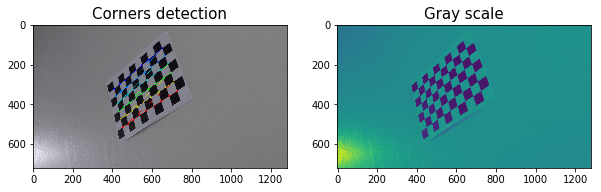

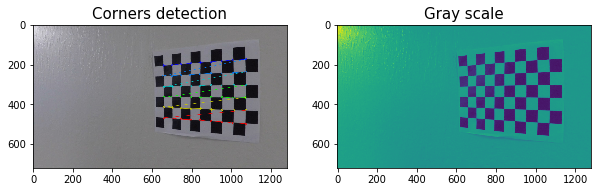

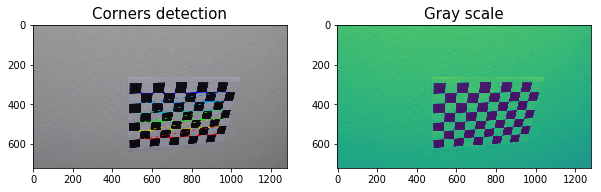

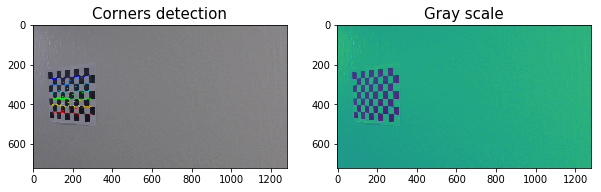

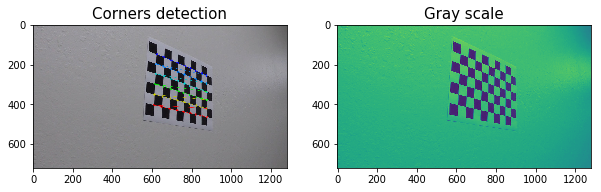

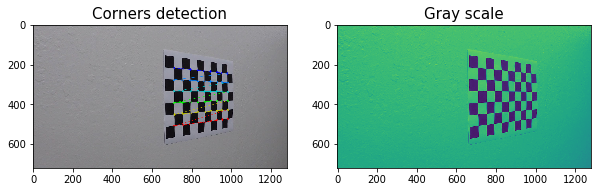

In [69]:
#---------------------------------CAMERA CALIBRATION AND TESTING---------------------------------#
def calibrate_camera():
    #Load calibration data
    calibration_images = glob.glob('camera_cal/calibration*.jpg')
    
    #Search for chessboard corners
    for fname in calibration_images:
        image = mpimg.imread(fname)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        # If it finds corners: adds to objectpoints and to image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(image, (nx,ny), corners, ret)
       
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
        ax1.imshow(image)
        ax1.set_title('Corners detection', fontsize=15)
        ax2.imshow(gray)
        ax2.set_title('Gray scale', fontsize=15)
    
    return objpoints, imgpoints

#Function test
objpoints, imgpoints = calibrate_camera()

#Print an example required by the rubic --- I could traverse the list for more examples but i dont find it interesting
print("From 3D point and its 2D point")
print()
print(objpoints[0][0])
print(imgpoints[0][0])

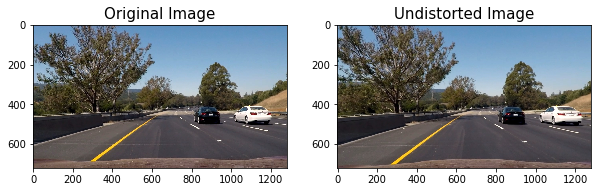

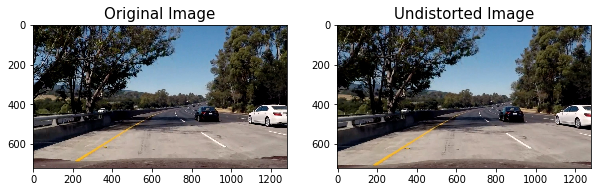

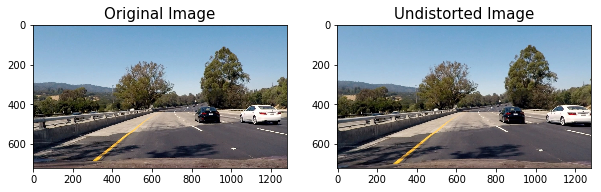

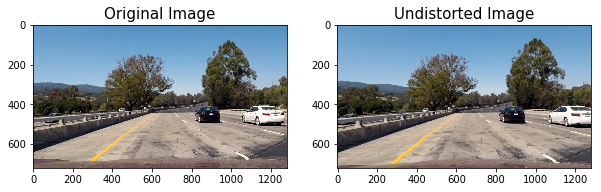

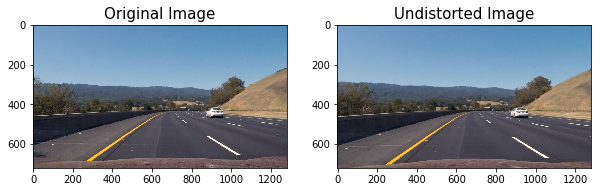

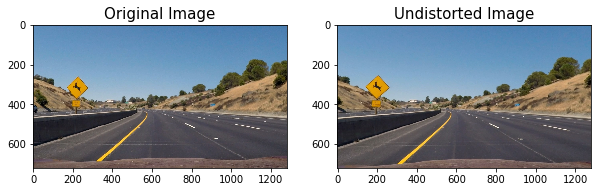

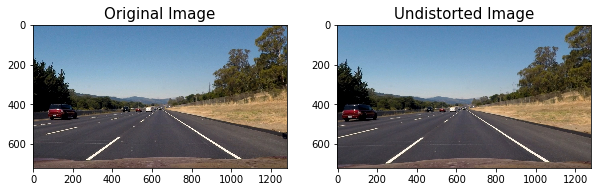

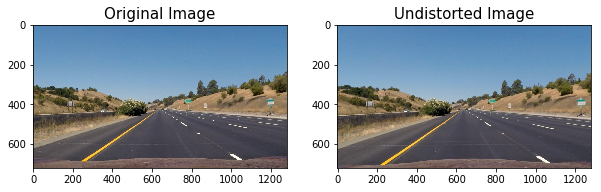

In [70]:
#---------------------------------IMAGE CALIBRATION AND TESTING---------------------------------#
def calibration_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]),None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

#Function test
def calibration_undistort_test():
    #calibrate_camera() --- only for testing if you dont run previous cell
    #Load test images
    test_images = glob.glob('test_images/*.jpg')
    for fname in (test_images):
        img = mpimg.imread(fname)
        undistorted = calibration_undistort(img, objpoints, imgpoints)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=15)
        ax2.imshow(undistorted)
        ax2.set_title('Undistorted Image', fontsize=15)
    return undistorted;

#Function run only
def calibration_undistort_run():
    #calibrate_camera() --- only for testing if you dont run previous cell
    #Load test images
    test_images = glob.glob('test_images/*.jpg')
    for fname in (test_images):
        img = mpimg.imread(fname)
        undistorted = calibration_undistort(img, objpoints, imgpoints)
    return undistorted;

image=calibration_undistort_test();

In [6]:
#---------------------------------GRADIENT THRESHOLDS---------------------------------#

#ABSOLUTE SOBEL
def abs_sobel(img, orient='x', sobel_kernel=3, threshold_sobel=(0,255)):
    #Gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient Sobel function
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale to 8 bit integer
    bit8_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #Copy and apply given thresholds
    grad_binary = np.zeros_like(bit8_sobel)
    grad_binary[(bit8_sobel >= threshold_sobel[0]) & (bit8_sobel <= threshold_sobel[1])] = 1
    return grad_binary

#MAGNITUDE OF GRADIENT
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    #Gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Take sobel gradient in both directions
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    #Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    #Rescale to 8 bit integer
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    #Copy and apply given thresholds
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

#DIRECTION OF GRADIENT
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    #Gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Take sobel gradient in both directions
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    #Calculate absolute value of gradient
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    #Copy and apply given thresholds
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

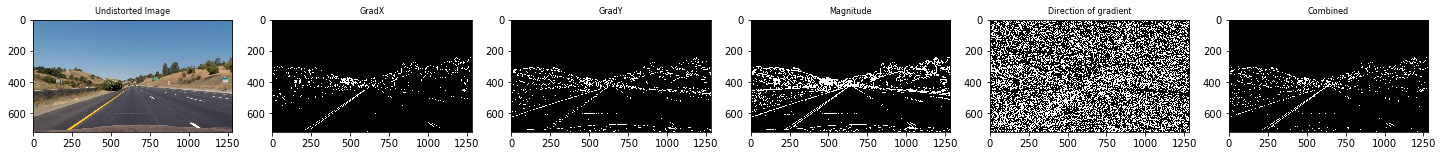

In [7]:
#---------------------------------GRADIENT THRESHOLDS TESTING---------------------------------#

def test_thresholds_gray():
    
    image=calibration_undistort_run();
    #Kernel size
    ksize = 3

    # Apply functions for thresholds
    gradx = abs_sobel(image, orient='x', sobel_kernel=ksize,threshold_sobel=(30,120))
    grady = abs_sobel(image, orient='y', sobel_kernel=ksize, threshold_sobel=(30,80))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 180))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.6, 1.0))
    #!!!The values of the threshold seem good for that particular image!!!#

    #COMBINE THRESHOLDS
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    #Plot the results
    f, (ax0, ax1, ax2,ax3,ax4,ax5) = plt.subplots(1, 6, figsize=(25,10))
    ax0.imshow(image)
    ax0.set_title('Undistorted Image', fontsize=8)
    ax1.imshow(gradx, cmap='gray')
    ax1.set_title('GradX', fontsize=8)
    ax2.imshow(grady, cmap='gray')
    ax2.set_title('GradY', fontsize =8)
    ax3.imshow(mag_binary, cmap='gray')
    ax3.set_title('Magnitude', fontsize =8)
    ax4.imshow(dir_binary, cmap='gray')
    ax4.set_title('Direction of gradient', fontsize =8)
    ax5.imshow(combined, cmap='gray')
    ax5.set_title('Combined', fontsize =8)
    
def thresholds_gray_run():
    
    image=calibration_undistort_run();
    
    #Kernel size
    ksize = 3

    # Apply functions for thresholds
    gradx = abs_sobel(image, orient='x', sobel_kernel=ksize,threshold_sobel=(30,120))
    grady = abs_sobel(image, orient='y', sobel_kernel=ksize, threshold_sobel=(30,80))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 180))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.6, 1.0))
    #!!!The values of the threshold seem good for that particular image!!!#

    #COMBINE THRESHOLDS
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined;
    
test_thresholds_gray();

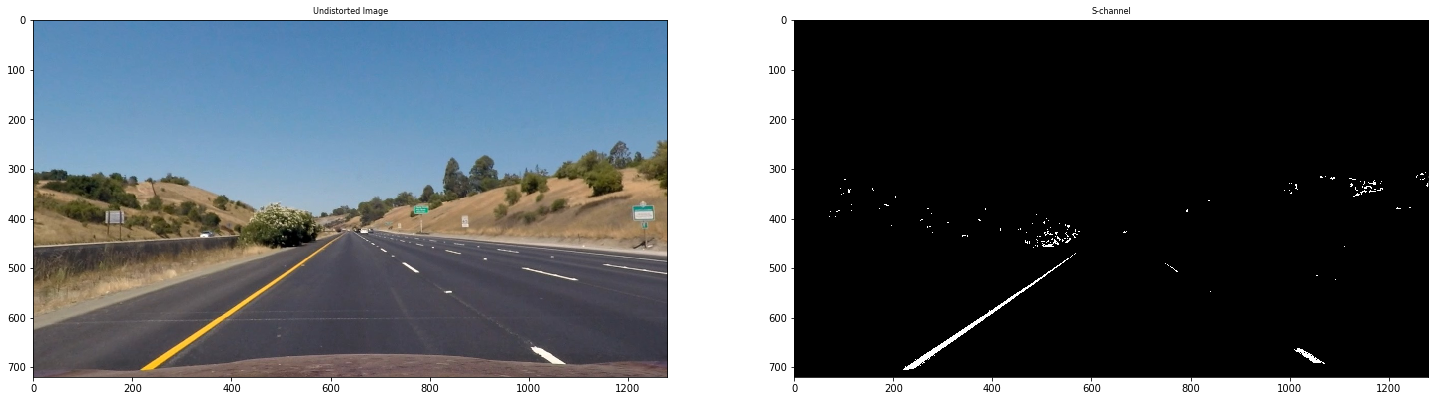

In [8]:
#---------------------------------COLOURS AND S-CHANNEL---------------------------------#

#Returns the s channel on the thresholds we have set
def hls_s_channel_select(img, thresh=(0, 255)):
    #Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #Split channels
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    #Copy and apply given thresholds
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1    
    return binary_output


#Test the S-channel function
def test_hls():
    image=calibration_undistort_run();
    s_channel=hls_s_channel_select(image, thresh=(160, 255))
    #!!!The values of the threshold seem good for that particular image!!!#
    #Plot the results
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,10))
    ax0.imshow(image)
    ax0.set_title('Undistorted Image', fontsize=8)
    ax1.imshow(s_channel, cmap='gray')
    ax1.set_title('S-channel', fontsize=8)
        
#Test the S-channel function
def hls_run():
    image=calibration_undistort_run();
    s_channel=hls_s_channel_select(image, thresh=(160, 255))
    #!!!The values of the threshold seem good for that particular image!!!#
    return s_channel;
    
test_hls();

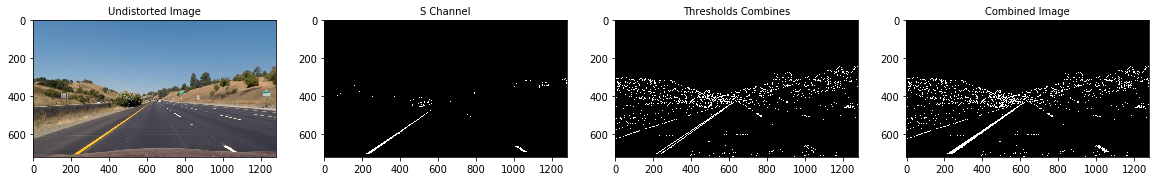

In [9]:
#---------------------------------COMBINE GRADIENT AND S-CHANNEL---------------------------------#

def combine(color, gradient):
    #Combine the thresholds
    combined = np.zeros_like(gradient)
    combined[(color == 1) | (gradient == 1)] = 1
    return combined

def combine_test():
    combined_gray=thresholds_gray_run()
    s_channel=hls_run()
    combined_image = combine(s_channel,combined_gray)
    #Plot the results
    f, (ax0, ax1,ax2, ax3) = plt.subplots(1, 4, figsize=(20,10))
    ax0.imshow(image)
    ax0.set_title('Undistorted Image', fontsize=10)
    ax1.imshow(s_channel, cmap='gray')
    ax1.set_title('S Channel', fontsize=10)
    ax2.imshow(combined_gray, cmap = 'gray')
    ax2.set_title('Thresholds Combines', fontsize =10)
    ax3.imshow(combined_image, cmap='gray')
    ax3.set_title('Combined Image', fontsize =10)
    
def combine_run():
    combined_gray=thresholds_gray_run()
    s_channel=hls_run()
    return combine(s_channel,combined_gray)

combine_test();

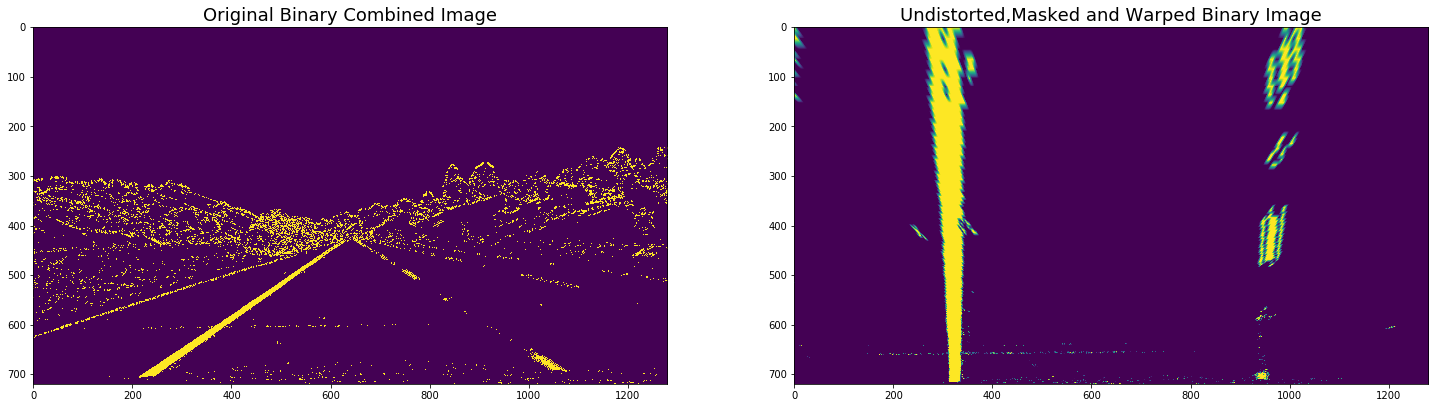

In [10]:
#---------------------------------TOP-WRAP PERCEPTIVE TRANSFORMATION---------------------------------#

def perspective_transform(img):
    src = np.float32([[585, 460],[200, 720],[1130, 720],[695, 460]])
    dst = np.float32([[320, 0], [320, 720],[960, 720],[960, 0]])
    #---hardcoded numbers from an image I used.Not complety sure about their correctness they seem to work for this porject----#
    #Calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped, M

def perspective_transform_test():
    combined_image=combine_run()
    top_wrap, perspective_M = perspective_transform(combined_image)
    inv_perspective_M=np.linalg.inv(perspective_M)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 9))
    ax1.imshow(combined_image)
    ax1.set_title('Original Binary Combined Image', fontsize=18)
    ax2.imshow(top_wrap)
    ax2.set_title('Undistorted,Masked and Warped Binary Image', fontsize=18)
    
def perspective_transform_run():
    combined_image=combine_run()
    top_wrap, perspective_M = perspective_transform(combined_image)
    inv_perspective_M=np.linalg.inv(perspective_M)
    return top_wrap,inv_perspective_M;

perspective_transform_test();
binary_warped,inv_perspective_M=perspective_transform_run();

In [11]:
#---------------------------------READY FUNCTION GIVEN IN THE LESSON---------------------------------#
#----some plots have been commented out since they create problem when running the pipeline----#

def window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.figure(figsize=(20,10))
    #plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #plt.figure(figsize=(30,20))
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    return left_fit, right_fit

#f, (ax1) = plt.subplots(1, 1, figsize=(25, 9))
#ax1.imshow(binary_warped)
left_fit, right_fit=window(binary_warped);

In [12]:
#---------------------------------READY FUNCTION GIVEN IN THE LESSON---------------------------------#
#----some plots have been commented out since they create problem when running the pipeline----#

def sliding_window(binary_warped,left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    return leftx, rightx, lefty, righty ,left_fitx, right_fitx,left_fit,right_fit,ploty,result

leftx, rightx, lefty, righty ,left_fitx, right_fitx,left_fit,right_fit,ploty,result=sliding_window(binary_warped,left_fit, right_fit);

10414.302937236193


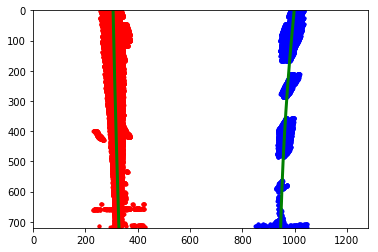

In [13]:
#---------------------------------READY FUNCTION GIVEN IN THE LESSON---------------------------------#
#----some plots have been commented out since they create problem when running the pipeline----#

def curvature(leftx, rightx, lefty, righty, left_fitx, right_fitx, left_fit, right_fit, ploty):  
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # print(left_curverad, right_curverad)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad


def curvature_test(leftx, rightx, lefty, righty, left_fitx, right_fitx, left_fit, right_fit, ploty):
    mark_size = 3
    plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    left_curverad, right_curverad = curvature(leftx,rightx,lefty,righty,left_fitx,right_fitx,left_fit, right_fit,ploty)
    curve = (left_curverad+right_curverad)/2.0
    print(curve)
    return curve;

curve=curvature_test(leftx, rightx, lefty, righty, left_fitx, right_fitx, left_fit, right_fit, ploty);

In [14]:
#---------------------------------FIND CENTER OF THE ROAD---------------------------------#
#---this method was suggested to me from fellow classmates in the facebook group---#
#---although it is not universal since it uses the approximate width of the road, it seems to work really well for the project---#

def position_to_center(left_fitx, right_fitx,result):
    lane_center = (left_fitx[-1] + right_fitx[-1])/2.0
    camera_center = result.shape[1]/2.0
    distance_from_center = (camera_center - lane_center)*3.7/700
    return distance_from_center

distance_from_center=position_to_center(left_fitx, right_fitx,result)
print(distance_from_center)

0.013379387873858214


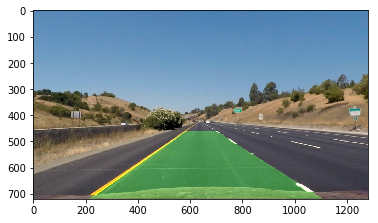

In [72]:
#---------------------------------READY FUNCTION GIVEN IN THE LESSON---------------------------------#
#----some plots have been commented out since they create problem when running the pipeline----#

def draw_the_lines(binary_warped,left_fitx, ploty,Minv,image,undist):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    return result;
    
image_with_line=draw_the_lines(binary_warped,left_fitx, ploty,inv_perspective_M,image,image)

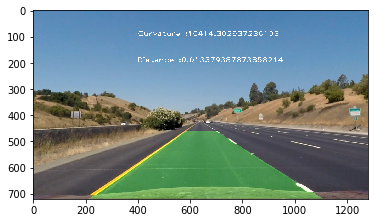

In [71]:
#---------------------------------WRITE ON THE IMAGES---------------------------------#
#----some plots have been commented out since they create problem when running the pipeline----#

def write_on_image(img,curve,distance):
    cv2.putText(img,"Curvature :"+str(curve), (400,100), cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2)
    cv2.putText(img,"Distance :"+str(distance), (400,200), cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2)
    plt.imshow(img)
    return img
    
final_image=write_on_image(image_with_line,curve,distance_from_center)

In [64]:
#---------------------------------PIPELINE---------------------------------
#--------After the individual stage testing time for the pipeline----------#
#----REDO GLOBAL VARIABLES----#

#Chessboard dimensions 
nx=9 
ny=6
#Arrays to store object points and image points from all the images.
objpoints = [] # Points in 3D 
imgpoints = [] # Point in 2D 
objp = np.zeros((ny*nx,3), np.float32) 
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
objpoints, imgpoints = calibrate_camera()

def advanced_lanes_pipeline(image):
    #undistorted image
    undistorted=calibration_undistort(image, objpoints, imgpoints)
    #Kernel size
    ksize = 3
    # Apply functions for thresholds
    gradx = abs_sobel(undistorted, orient='x', sobel_kernel=ksize,threshold_sobel=(30,120))
    grady = abs_sobel(undistorted, orient='y', sobel_kernel=ksize, threshold_sobel=(30,80))
    mag_binary = mag_thresh(undistorted, sobel_kernel=ksize, mag_thresh=(30, 180))
    dir_binary = dir_threshold(undistorted, sobel_kernel=ksize, thresh=(0.60, 1.0))
    #!!!The values of the threshold seem good for that particular image!!!#
    #COMBINE THRESHOLDS
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #get s-channel
    s_channel=hls_s_channel_select(undistorted, thresh=(160, 255))
    #combine s-channel and gradient
    combined_image=combine(s_channel, combined)
    #perpective transform
    binary_warped, perspective_M = perspective_transform(combined_image)
    inv_perspective_M=np.linalg.inv(perspective_M)
    #windoing no1 layer
    left_fit, right_fit=window(binary_warped);
    #sliding windowing
    leftx, rightx, lefty, righty ,left_fitx, right_fitx,left_fit,right_fit,ploty,result=sliding_window(binary_warped,left_fit, right_fit);
    #calculate curve
    left_curverad, right_curverad = curvature(leftx,rightx,lefty,righty,left_fitx,right_fitx,left_fit, right_fit,ploty)
    curve = (left_curverad+right_curverad)/2.0
    #calculate distance from center
    distance_from_center=position_to_center(left_fitx, right_fitx,result)
    #draw the lines
    image_with_line=draw_the_lines(binary_warped,left_fitx, ploty,inv_perspective_M,undistorted,undistorted)
    #write on the image
    show_image=write_on_image(image_with_line,curve,distance_from_center)
    return show_image;

In [66]:
#The following method to handle the video was suggested in Project 1

def process_image(image):
    return advanced_lanes_pipeline(image)

white_output = 'output/final_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video output/final_result.mp4
[MoviePy] Writing video output/final_result.mp4


100%|█████████▉| 1260/1261 [10:27<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/final_result.mp4 

CPU times: user 34min 39s, sys: 3min 41s, total: 38min 21s
Wall time: 10min 27s
